## Imports

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

## Hyperparameters

In [44]:
timesteps = 10
hidden_size = 64
epochs = 200
learning_rate = 0.0001
seed = 42

In [45]:
np.random.seed(seed)

## Load, plot, and analyze data

In [46]:
def load_temperature_data():
    data = pd.read_excel('Temperature.xlsx', header=None)
    return data.iloc[:, 0].values

In [47]:
def analyze_data(data, filename_prefix='temperature_analysis'):
    data_series = pd.Series(data)
    print("Descriptive statistics of Temperature data:")
    print(data_series.describe())

    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Temperature Data')
    plt.title('Time Series of Temperature Data')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

    plt.figure(figsize=(8, 6))
    data_series.hist(bins=30)
    plt.title('Histogram of Temperature Data Distribution')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    plt.close()

    plt.figure(figsize=(12, 6))
    plot_acf(data_series, lags=50)
    plt.title('Autocorrelation of Temperature Data')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.grid(True)
    plt.show()
    plt.close()

In [48]:
def plot_data(data, train_data, test_data, predictions=None):
    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Full Temperature Data', alpha=0.5)
    plt.plot(range(len(train_data)), train_data, label='Training Data', color='blue')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data,
             label='Test Data', color='orange')
    if predictions is not None:
        plt.plot(range(len(train_data), len(train_data) + len(predictions)),
                 predictions[:, -1], label='GRU Predictions', color='red')  # فقط آخرین خروجی
    plt.title('Distribution and Prediction of Temperature Data')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

In [49]:
def plot_regression(y_true, y_pred, title, filename):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')
    plt.title(title)
    plt.xlabel('Actual Values (°C)')
    plt.ylabel('Predicted Values (°C)')
    plt.grid(True)
    plt.show()
    plt.close()

## Preprocess data

In [50]:
def normalize_data(data):
    min_val, max_val = np.min(data), np.max(data)
    normalized = (data - min_val) / (max_val - min_val)
    return normalized, min_val, max_val

In [51]:
def denormalize_data(normalized, min_val, max_val):
    normalized = np.array(normalized)
    return normalized * (max_val - min_val) + min_val

In [52]:
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps - timesteps + 2):
        X.append(data[i:i + timesteps])
        y.append(data[i + 2:i + timesteps + 2])
    return np.array(X), np.array(y)

## Activation functions

In [53]:
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

In [54]:
def sigmoid_derivative(output):
    return output * (1 - output)

In [55]:
def tanh(x):
    return np.tanh(np.clip(x, -500, 500))

In [56]:
def tanh_derivative(output):
    return 1 - output ** 2

## Loss functions

In [57]:
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [58]:
def mse_loss_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

In [59]:
def mae_loss(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

## Model

In [60]:
class GRUCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        limit = np.sqrt(6 / (hidden_size + input_size))
        self.Wz = np.random.uniform(-limit, limit, (hidden_size, hidden_size + input_size))
        self.Wr = np.random.uniform(-limit, limit, (hidden_size, hidden_size + input_size))
        self.Wh = np.random.uniform(-limit, limit, (hidden_size, hidden_size + input_size))
        self.bz = np.zeros(hidden_size)
        self.br = np.zeros(hidden_size)
        self.bh = np.zeros(hidden_size)
        self.Wy = np.random.uniform(-limit, limit, (1, hidden_size))
        self.by = np.zeros(1)

    def forward(self, x, h_prev):
        self.x, self.h_prev = x, h_prev
        self.combined = np.hstack((h_prev, x))
        self.z = sigmoid(np.dot(self.Wz, self.combined) + self.bz)
        self.r = sigmoid(np.dot(self.Wr, self.combined) + self.br)
        self.combined_reset = np.hstack((self.r * h_prev, x))
        self.h_hat = tanh(np.dot(self.Wh, self.combined_reset) + self.bh)
        self.h = (1 - self.z) * h_prev + self.z * self.h_hat
        self.y_pred = np.dot(self.Wy, self.h) + self.by
        return self.y_pred, self.h

    def backward(self, dL_dy, dh_next, learning_rate):
        dL_dy = np.array(dL_dy).reshape(-1)  # اطمینان از شکل (1,)
        dy_dh = self.Wy
        dh = np.dot(dy_dh.T, dL_dy) + dh_next
        dz = dh * (self.h_hat - self.h_prev) * sigmoid_derivative(self.z)
        dh_hat = dh * self.z * tanh_derivative(self.h_hat)
        dcombined_reset = np.dot(self.Wh.T, dh_hat)
        dr = dcombined_reset[:self.hidden_size] * self.h_prev * sigmoid_derivative(self.r)
        dWz = np.dot(dz.reshape(-1, 1), self.combined.reshape(1, -1))
        dWr = np.dot(dr.reshape(-1, 1), self.combined.reshape(1, -1))
        dWh = np.dot(dh_hat.reshape(-1, 1), self.combined_reset.reshape(1, -1))
        dbz = dz
        dbr = dr
        dbh = dh_hat
        dWy = np.dot(dL_dy.reshape(-1, 1), self.h.reshape(1, -1))
        dby = dL_dy
        clip_value = 1.0
        dWz = np.clip(dWz, -clip_value, clip_value)
        dWr = np.clip(dWr, -clip_value, clip_value)
        dWh = np.clip(dWh, -clip_value, clip_value)
        dbz = np.clip(dbz, -clip_value, clip_value)
        dbr = np.clip(dbr, -clip_value, clip_value)
        dbh = np.clip(dbh, -clip_value, clip_value)
        dWy = np.clip(dWy, -clip_value, clip_value)
        dby = np.clip(dby, -clip_value, clip_value)
        self.Wz -= learning_rate * dWz
        self.Wr -= learning_rate * dWr
        self.Wh -= learning_rate * dWh
        self.bz -= learning_rate * dbz
        self.br -= learning_rate * dbr
        self.bh -= learning_rate * dbh
        self.Wy -= learning_rate * dWy
        self.by -= learning_rate * dby.reshape(-1)
        dcombined_z = np.dot(self.Wz.T, dz)[:self.hidden_size]
        dcombined_r = np.dot(self.Wr.T, dr)[:self.hidden_size]
        dcombined_h = np.dot(self.Wh.T, dh_hat)[:self.hidden_size]
        dcombined = dcombined_z + dcombined_r + dcombined_h
        dh_prev = dcombined + dh * (1 - self.z)
        return dh_prev

## Train model

In [61]:
def train_model(model, X_train, y_train, epochs, learning_rate):
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(len(X_train)):
            x_seq = X_train[i]
            y_true_seq = y_train[i]
            h_t = np.zeros(model.hidden_size)
            states = []
            y_preds = []

            # Forward pass and store states
            for t in range(len(x_seq)):
                x_t = x_seq[t].reshape(-1)
                y_pred, h_t = model.forward(x_t, h_t)
                y_preds.append(y_pred[0])  # جمع‌آوری خروجی اسکالر
                states.append((model.x, model.h_prev, model.combined, model.z, model.r,
                              model.combined_reset, model.h_hat, model.h))

            # Compute loss for all outputs
            y_preds = np.array(y_preds)
            loss = mse_loss(y_true_seq, y_preds)
            epoch_loss += loss

            # Backward pass
            dh_next = np.zeros(model.hidden_size)
            for t in reversed(range(len(x_seq))):
                model.x, model.h_prev, model.combined, model.z, model.r, \
                model.combined_reset, model.h_hat, model.h = states[t]
                dL_dy = mse_loss_derivative(y_true_seq[t], y_preds[t])
                dh_next = model.backward(dL_dy, dh_next, learning_rate)

        avg_loss = epoch_loss / len(X_train)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.6f}")
    return losses

## Predict

In [62]:
def predict(model, X, timesteps):
    predictions = []
    for i in range(len(X)):
        x_seq = X[i]
        h_t = np.zeros(model.hidden_size)
        y_preds = []
        for t in range(timesteps):
            x_t = x_seq[t].reshape(-1)
            y_pred, h_t = model.forward(x_t, h_t)
            y_preds.append(y_pred[0])
        predictions.append(y_preds)
    predictions = np.array(predictions)
    return predictions

## Main

### Load & analyze data

In [63]:
data = load_temperature_data()

Analyzing raw Temperature data...
Descriptive statistics of Temperature data:
count    336.000000
mean      19.902679
std        8.975760
min       -1.800000
25%       12.000000
50%       20.400000
75%       28.000000
max       37.800000
dtype: float64


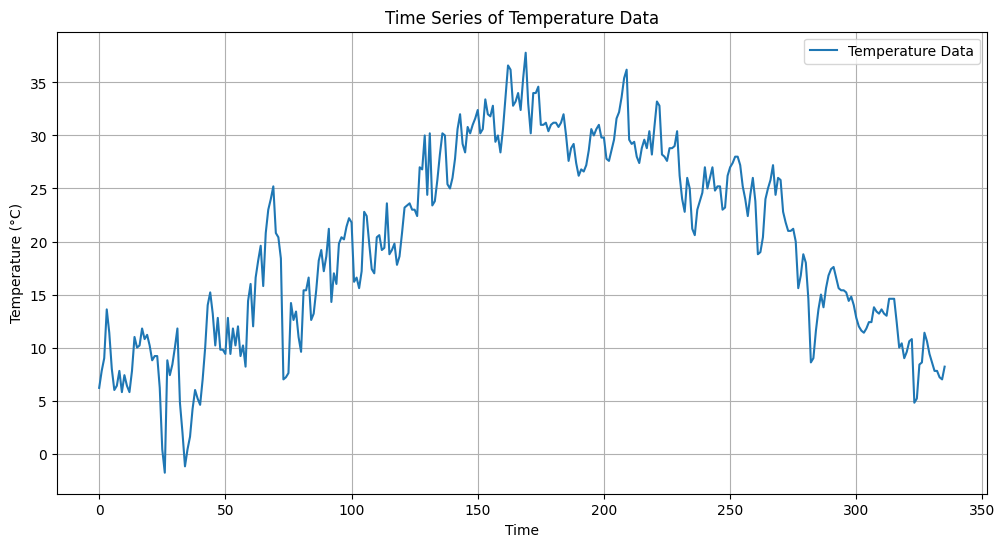

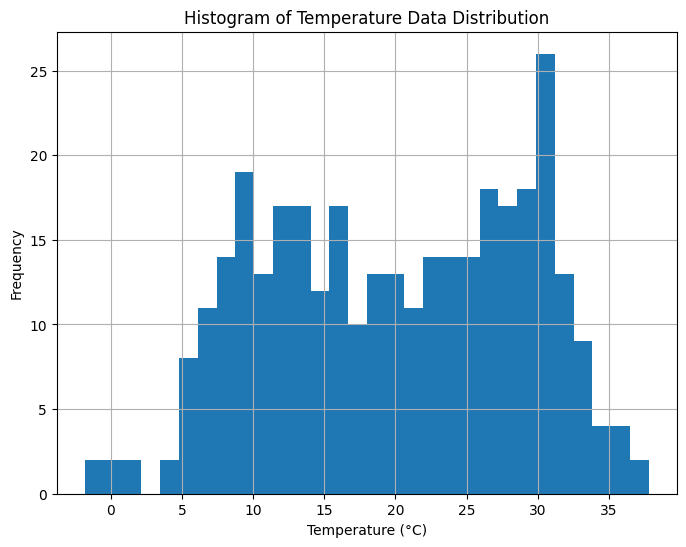

<Figure size 1200x600 with 0 Axes>

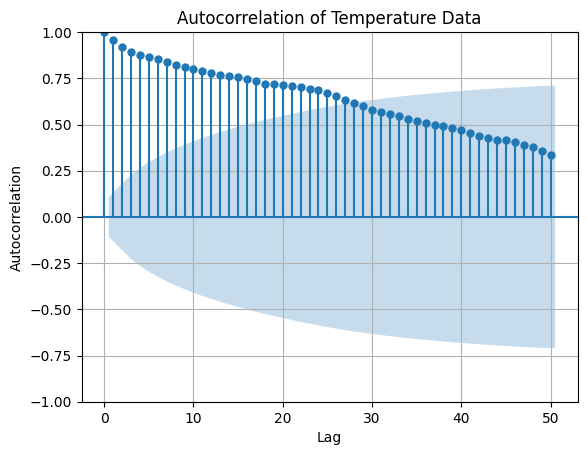

In [64]:
print("Analyzing raw Temperature data...")
analyze_data(data)

### Preprocess data

In [65]:
data_normalized, min_val, max_val = normalize_data(data)

In [66]:
X, y = create_sequences(data_normalized, timesteps)

In [67]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (318, 10), y shape: (318, 10)


### Train/Test Split

In [68]:
train_size = int(0.8 * len(X))

In [69]:
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [70]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (254, 10), y_train shape: (254, 10)
X_test shape: (64, 10), y_test shape: (64, 10)


### Visualize raw data

In [71]:
train_data = denormalize_data(X_train[:, 0], min_val, max_val)
test_data = denormalize_data(X_test[:, 0], min_val, max_val)

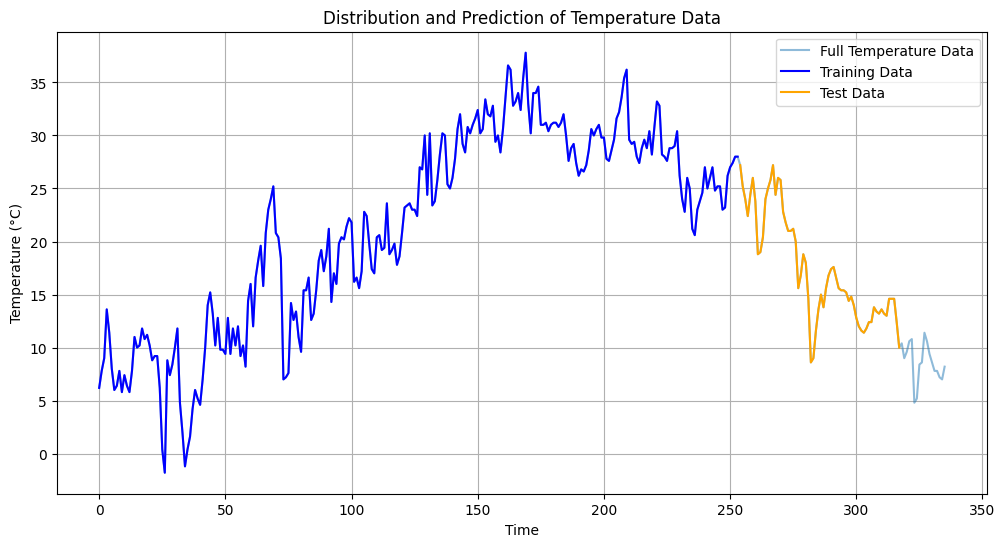

In [72]:
plot_data(data, train_data, test_data)

### Model Creation

In [73]:
model = GRUCell(input_size=1, hidden_size=hidden_size)

### Train model

In [85]:
print("Training GRU...")
losses = train_model(model, X_train, y_train, epochs, learning_rate)

Training GRU...
Epoch 1/200, Loss: 0.007797
Epoch 2/200, Loss: 0.007794
Epoch 3/200, Loss: 0.007790
Epoch 4/200, Loss: 0.007786
Epoch 5/200, Loss: 0.007782
Epoch 6/200, Loss: 0.007779
Epoch 7/200, Loss: 0.007775
Epoch 8/200, Loss: 0.007772
Epoch 9/200, Loss: 0.007768
Epoch 10/200, Loss: 0.007765
Epoch 11/200, Loss: 0.007761
Epoch 12/200, Loss: 0.007758
Epoch 13/200, Loss: 0.007754
Epoch 14/200, Loss: 0.007751
Epoch 15/200, Loss: 0.007748
Epoch 16/200, Loss: 0.007745
Epoch 17/200, Loss: 0.007742
Epoch 18/200, Loss: 0.007738
Epoch 19/200, Loss: 0.007735
Epoch 20/200, Loss: 0.007732
Epoch 21/200, Loss: 0.007729
Epoch 22/200, Loss: 0.007726
Epoch 23/200, Loss: 0.007723
Epoch 24/200, Loss: 0.007720
Epoch 25/200, Loss: 0.007717
Epoch 26/200, Loss: 0.007714
Epoch 27/200, Loss: 0.007712
Epoch 28/200, Loss: 0.007709
Epoch 29/200, Loss: 0.007706
Epoch 30/200, Loss: 0.007703
Epoch 31/200, Loss: 0.007700
Epoch 32/200, Loss: 0.007698
Epoch 33/200, Loss: 0.007695
Epoch 34/200, Loss: 0.007692
Epoch 3

## Result

### Get Prediction

In [86]:
train_predictions_normalized = predict(model, X_train, timesteps)
test_predictions_normalized = predict(model, X_test, timesteps)

In [87]:
print(f"train_predictions shape before denorm: {train_predictions_normalized.shape}")
print(f"test_predictions shape before denorm: {test_predictions_normalized.shape}")

train_predictions shape before denorm: (254, 10)
test_predictions shape before denorm: (64, 10)


### Denormalize predictions

In [88]:
train_predictions = denormalize_data(train_predictions_normalized, min_val, max_val)
test_predictions = denormalize_data(test_predictions_normalized, min_val, max_val)

In [89]:
y_train_denorm = denormalize_data(y_train, min_val, max_val)
y_test_denorm = denormalize_data(y_test, min_val, max_val)

In [90]:
print(f"train_predictions shape after denorm: {train_predictions.shape}")
print(f"test_predictions shape after denorm: {test_predictions.shape}")

train_predictions shape after denorm: (254, 10)
test_predictions shape after denorm: (64, 10)


### Evaluate model

In [91]:
train_mse = mse_loss(y_train_denorm, train_predictions)
test_mse = mse_loss(y_test_denorm, test_predictions)
train_mae = mae_loss(y_train_denorm, train_predictions)
test_mae = mae_loss(y_test_denorm, test_predictions)

In [92]:
print(f"Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")

Train MSE: 11.8278, Train MAE: 2.6638
Test MSE: 9.5224, Test MAE: 2.3126


### Visualize

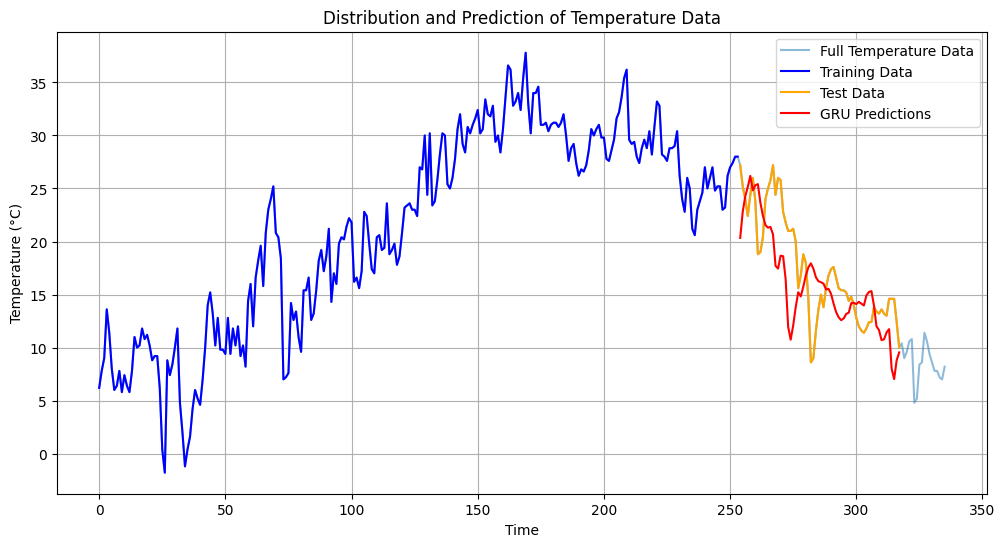

In [93]:
plot_data(data, train_data, test_data, test_predictions)

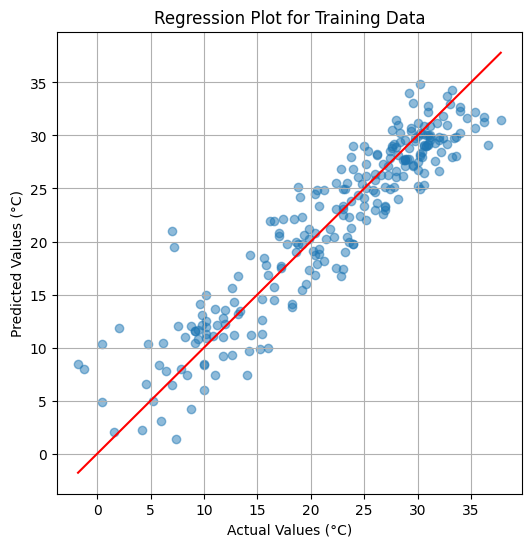

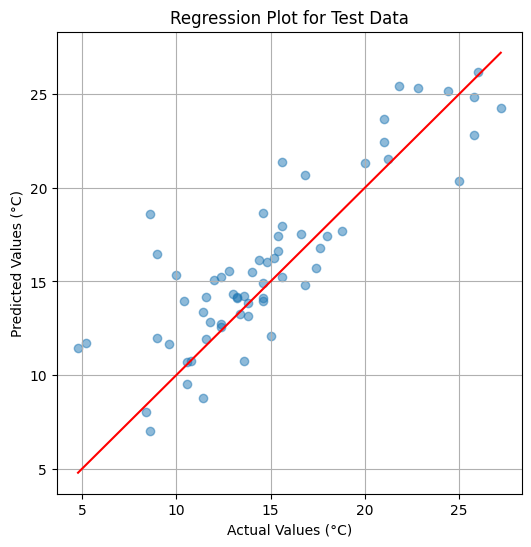

In [94]:
plot_regression(y_train_denorm[:, -1], train_predictions[:, -1],
                "Regression Plot for Training Data", "regression_train.png")
plot_regression(y_test_denorm[:, -1], test_predictions[:, -1],
                "Regression Plot for Test Data", "regression_test.png")

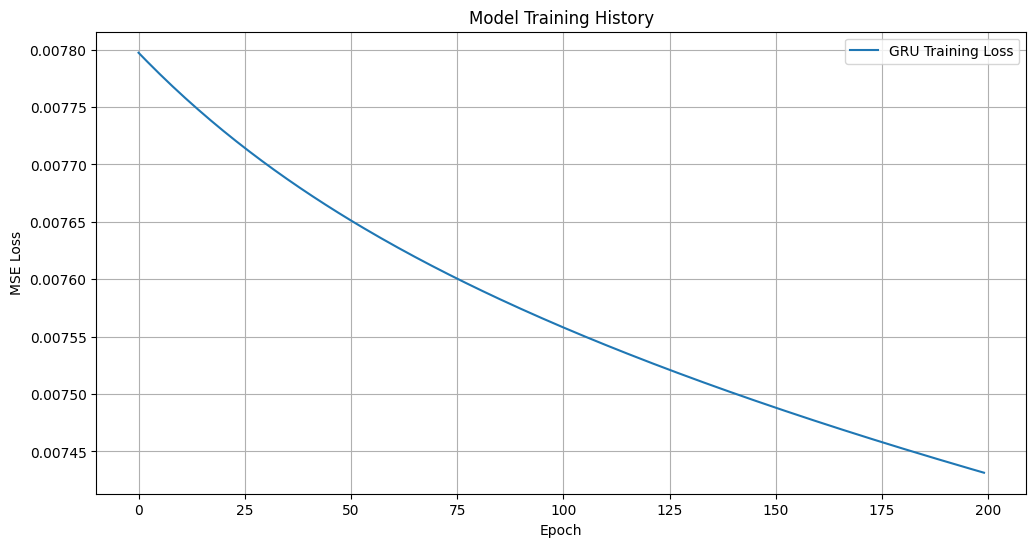

In [95]:
plt.figure(figsize=(12, 6))
plt.plot(losses, label='GRU Training Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.close()